<a href="https://colab.research.google.com/github/ymuto0302/PJ2024/blob/main/GIS3_4_virtual_market_area_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 地理情報の活用(3-4)：仮想店舗・仮想居住地における商圏人口の推定
単純な例を用いて，商圏に居住する人口を数える方法を説明する。

---
## (準備) rtree および GeoPandas のインストール
GeoPandas の空間結合(spatial join) `sjoin()` を利用するため，ライブラリ "rtree" が必要となる。

GeoPandas との整合性の関係から，rtree や shapely のインストール後に GeoPandas をインストールする。

In [1]:
!pip install pandas fiona shapely pyproj rtree
!pip install geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.2/535.2 kB 5.9 MB/s eta 0:00:00


---
## 仮想的な居住地および店舗の設定
下図のように，３つの居住地および２つの店舗を設定する。

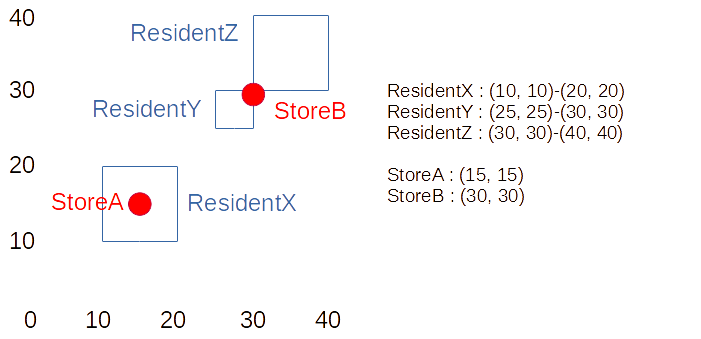

---
## 居住地域およびその人口の定義
３つの居住地域および各地域に住む人口を設定する例を示す。
ここで，居住地域はポリゴンとして定義される。

In [2]:
import geopandas as gpd
from shapely.geometry import Polygon

# 居住地の名称
resident_names = ["ResidentX", "ResidentY", "ResidentZ"]

# 居住地の設定
cordinates = [[(10, 10), (20, 10), (20, 20), (10, 20)],
              [(25, 25), (30, 25), (30, 30), (25, 30)],
              [(30, 30), (40, 30), (40, 40), (30, 40)]]

# 各居住地の人口
pops = [30, 50, 70]

# [[居住地A, 人口A, Polygon-A], [居住地B, 人口B, Polygon-B], ...] の形のリストを作る
data = list()
for resident_name, cordinate, pop in zip(resident_names, cordinates, pops):
    data.append([resident_name, pop, Polygon(cordinate)])

# リストを GeoDataFrame へ変換
residents = gpd.GeoDataFrame(data, columns=['resident', 'population', 'geometry'], crs='EPSG:4612')

# 変数 residents の中身を確認
residents

,resident,population,geometry
0,ResidentX,30,"POLYGON ((10.00000 10.00000, 20.00000 10.00000..."
1,ResidentY,50,"POLYGON ((25.00000 25.00000, 30.00000 25.00000..."
2,ResidentZ,70,"POLYGON ((30.00000 30.00000, 40.00000 30.00000..."


居住地域を可視化する。

この図に人口は反映されない。すなわち，`plot()` メソッドが見ているのは geometry のみである。

予め定義したように，GeoDataFrame 上では，左下の矩形に 30人，中央の矩形に 50人，右上の矩形に 70人の人口が紐づいている。

<Axes: >

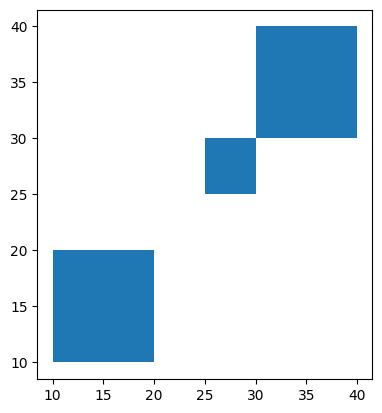

In [3]:
# 可視化 (確認用)
residents.plot()

## 店舗および商圏の定義
以下では２つの店舗を考える。
shop A は，上図の左下の矩形内に存在する。また，shop B は右上の区間の左下隅に存在する。

In [4]:
# 店舗の定義
from shapely.geometry import Point

stores = gpd.GeoDataFrame([['storeA', Point(15, 15)],
                           ['storeB', Point(30, 30)]],
                           columns=['name', 'geometry'],
                           crs='EPSG:4612')

# 変数の中身を覗き見る
stores

,name,geometry
0,storeA,POINT (15.00000 15.00000)
1,storeB,POINT (30.00000 30.00000)


店舗を中心とした半径 "buffer_size" の領域を商圏とする。

次のように `buffer()` メソッドにより商圏をポリゴンとして生成できる。

In [5]:
# 商圏の定義
# ポイント(Point)のバッファをとると，ポリゴンを作ることができる
buffer_size = 10
trade_areas = stores.copy() # name 列を引き継ぐため，コピーする
trade_areas['geometry'] = stores.buffer(buffer_size)

# 変数の中身を覗き見ると，確かにポリゴンになっている！
trade_areas

<ipython-input-5-d3cf2aa6b379>:5: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  trade_areas['geometry'] = stores.buffer(buffer_size)


,name,geometry
0,storeA,"POLYGON ((25.00000 15.00000, 24.95185 14.01983..."
1,storeB,"POLYGON ((40.00000 30.00000, 39.95185 29.01983..."


## 居住地と商圏の可視化
居住地 `residents` と商圏 `trade_areas` を可視化し，これらの位置関係を確認する。

居住地を青色，商圏を赤（透明度 0.4）で表現した。

図の左下では，商圏内に居住地がすっぽり含まれることが分かる。また，右上では，居住地の一部が商圏内に入りきれない状態である。

<Axes: >

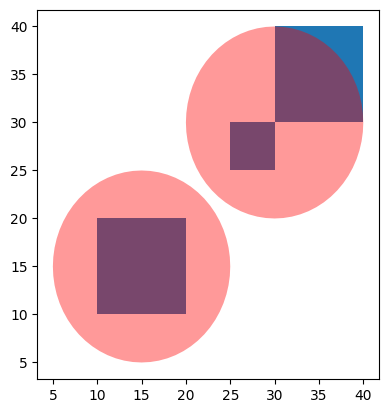

In [6]:
# 試しに可視化してみる
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1)
residents.plot(ax=ax)
trade_areas.plot(ax=ax, color='red', alpha=0.4)

## (今回のポイント！）居住地と商圏を空間的に結合した GeoDataFrame の生成
空間結合 (spatial join) とは，２つのポリゴン（領域）の重なったデータを取り出す操作である。
次のように `geopandas.sjoin()` により実現でき，その文法は以下のとおりである。

    geopandas.sjoin(刺されるデータフレーム，刺すデータフレーム，predicate=操作)
    
predicate に指定できる操作として 'within', 'intersects', 'contatins' 等がある。

In [7]:
# residents と trade area の空間結合 (spatial join)
joined = gpd.sjoin(residents, trade_areas, predicate='within')

上記の例では，操作として 'within' を指定している。
上記の命令は「`residents` は `trade_areas` の内部 (within) か？」という意味であり，
商圏 `trade_areas` に完全に含まれる領域およびそこに居住する人口が抽出される。

この例では
- storeA の商圏に含まれる領域は Resident X である。
- storeB の商圏に含まれる領域は Resident Y である。

In [8]:
# sjoin された結果を表示
joined

,resident,population,geometry,index_right,name
0,ResidentX,30,"POLYGON ((10.00000 10.00000, 20.00000 10.00000...",0,storeA
1,ResidentY,50,"POLYGON ((25.00000 25.00000, 30.00000 25.00000...",1,storeB


(参考) 空間結合された GeoDataFrame `joined` を可視化すると，ResidentX および ResidentY のみが選択されていることが分かる。

<Axes: >

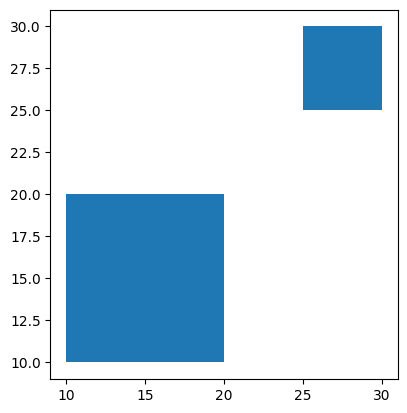

In [9]:
# 一応，可視化 (Resident X および Y のみが表示される）
joined.plot()

---
# 現実的な商圏人口の求め方
改めて確認しよう。  
本節では，商圏に含まれる「複数の居住地」に居住する人口の合計を求めることが目的である。

下図のように，４つの居住地および２つの店舗を設定する。

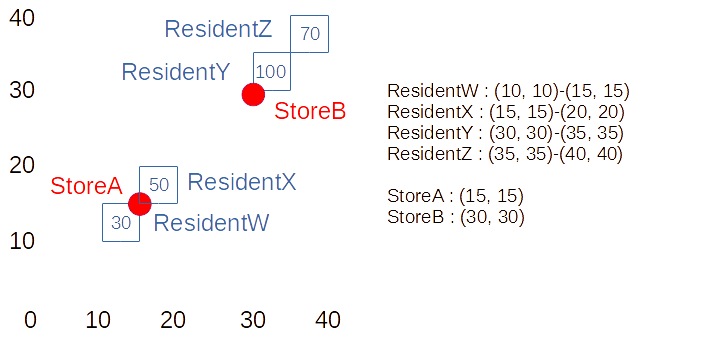

最初に４つの居住地を設定する。コードと可視化した結果を突き合わせれば，意味が分かるだろう。

<Axes: >

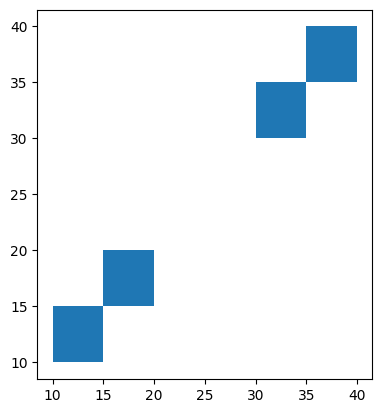

In [10]:
import geopandas as gpd
from shapely.geometry import Polygon
import fiona
from fiona.crs import from_epsg

# 居住地の名称
resident_names = ['ResidentW', 'ResidentX', 'ResidentY', 'ResidentZ']

# polygon を作る場合，境界線を結ぶ順番に座標を並べる
cordinates = [[(10, 10), (15, 10), (15, 15), (10, 15)],
              [(15, 15), (20, 15), (20, 20), (15, 20)],
              [(30, 30), (35, 30), (35, 35), (30, 35)],
              [(35, 35), (40, 35), (40, 40), (35, 40)]
             ]

pops = [30, 50, 100, 70]

# [[人口A, Polygon-A], [人口B, Polygon-B], ...] の形のリストを作る
data = list()
for resident_name, cordinate, pop in zip(resident_names, cordinates, pops):
    data.append([resident_name, pop, Polygon(cordinate)])

# GeoDataFrame の生成
residents = gpd.GeoDataFrame(data, columns=['resident', 'population', 'geometry'], crs='EPSG:4612')

# 可視化 (確認用)
residents.plot()

In [11]:
# 変数 residents の中身を確認
residents

,resident,population,geometry
0,ResidentW,30,"POLYGON ((10.00000 10.00000, 15.00000 10.00000..."
1,ResidentX,50,"POLYGON ((15.00000 15.00000, 20.00000 15.00000..."
2,ResidentY,100,"POLYGON ((30.00000 30.00000, 35.00000 30.00000..."
3,ResidentZ,70,"POLYGON ((35.00000 35.00000, 40.00000 35.00000..."


続けて，２つの店舗を定義し，それぞれの商圏を設定する。

In [12]:
# 店舗の定義
from shapely.geometry import Point
import fiona
from fiona.crs import from_epsg

stores = gpd.GeoDataFrame([['storeA', Point(15, 15)],
                           ['storeB', Point(30, 30)]],
                          columns=['name', 'geometry'],
                          crs='EPSG:4612')

In [13]:
# 商圏の設定
# ポイント(Point)のバッファをとると，ポリゴンを作ることができる
buffer_size = 10 # 10[m]
trade_areas = stores.copy() # 'name 列を引き継ぐため，コピーする'
trade_areas['geometry'] = stores.buffer(buffer_size)

<ipython-input-13-d686bdfa7957>:5: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  trade_areas['geometry'] = stores.buffer(buffer_size)


In [14]:
# 変数 trade_areas の中身を確認
trade_areas

,name,geometry
0,storeA,"POLYGON ((25.00000 15.00000, 24.95185 14.01983..."
1,storeB,"POLYGON ((40.00000 30.00000, 39.95185 29.01983..."


居住地と商圏の位置関係を可視化した結果を以下に示す。
- 図の左下が "storeA" の商圏，右上が "storeB" の商圏である。
- "storeA" の商圏には２つの居住地が，"storeB" の商圏には１つの居住地が含まれている。

<Axes: >

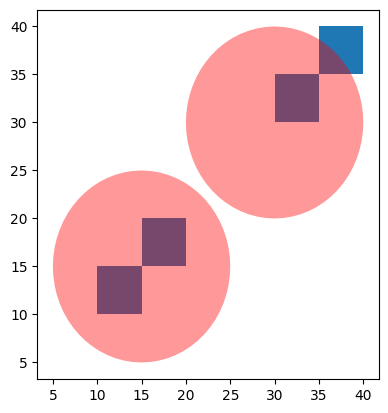

In [15]:
# 試しに可視化してみる
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1)
residents.plot(ax=ax)
trade_areas.plot(ax=ax, color='red', alpha=0.4)

これらを空間結合した結果を以下に示す。

"shopA" と２つの居住地 (Resident A と Rsident B) が対応づけられたことが分かるだろう。

In [16]:
# resident と shopping area の空間的な(spatial)結合
joined = gpd.sjoin(residents, trade_areas, predicate='within')

# joined の中身を表示
joined

,resident,population,geometry,index_right,name
0,ResidentW,30,"POLYGON ((10.00000 10.00000, 15.00000 10.00000...",0,storeA
1,ResidentX,50,"POLYGON ((15.00000 15.00000, 20.00000 15.00000...",0,storeA
2,ResidentY,100,"POLYGON ((30.00000 30.00000, 35.00000 30.00000...",1,storeB


<Axes: >

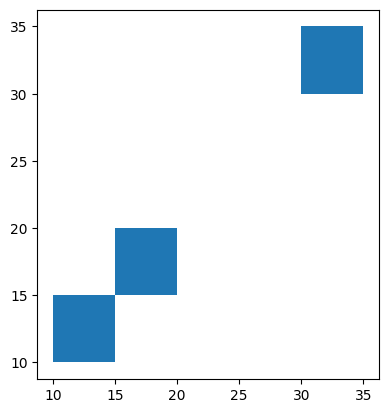

In [17]:
# 一応，可視化して確かめてみる
joined.plot()

---
## (今回のポイント！）それぞれの商圏に含まれる人口をカウントする
空間結合されたデータ (変数名 `joined`) を「店舗の名称 (列名 `name`)」でグルーピングする。

下記のとおり，"storeA" と紐付けられたグループには２つのポリゴンが含まれる。

In [18]:
# (注意) groupby の機能を学生へ説明するためのコード
# ひとつの店舗が複数のポリゴンをカバーすることから，これらをまとめる
for name, group in joined.groupby('name'):
    print(name, group)

storeA     resident  population                                           geometry  \
0  ResidentW          30  POLYGON ((10.00000 10.00000, 15.00000 10.00000...   
1  ResidentX          50  POLYGON ((15.00000 15.00000, 20.00000 15.00000...   

   index_right    name  
0            0  storeA  
1            0  storeA  
storeB     resident  population                                           geometry  \
2  ResidentY         100  POLYGON ((30.00000 30.00000, 35.00000 30.00000...   

   index_right    name  
2            1  storeB  


グループ内の人口(列名 `population`)を合計することで，"shopA", "shopB" の商圏に含まれる人口が得られる。

すなわち，
- "storeA"の商圏：ResidentA (人口 30人) とResidentB (人口 50人)の和
- "storeB"の商圏：RsidentC (人口 100人)のみ

In [19]:
# ひとつの店舗が複数のポリゴンをカバーすることから，これらをまとめる
for name, group in joined.groupby('name'):
    total = group['population'].sum() # グループ内の合計を得る
    print("{}の商圏人口：{}人".format(name, total))

storeAの商圏人口：80人
storeBの商圏人口：100人


---
### (参考) `sjoin` の操作(predicate) に within, intersects, contains を指定した場合の挙動

    resident  population                                           geometry  \
0  ResidentW          30  POLYGON ((10.00000 10.00000, 15.00000 10.00000...   
1  ResidentX          50  POLYGON ((15.00000 15.00000, 20.00000 15.00000...   
2  ResidentY         100  POLYGON ((30.00000 30.00000, 35.00000 30.00000...   

   index_right    name  
0            0  storeA  
1            0  storeA  
2            1  storeB  


<Axes: >

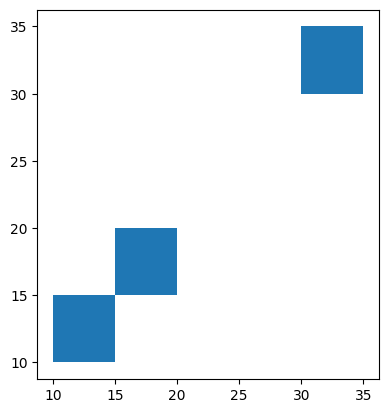

In [20]:
# resident と shopping area の空間的な(spatial)結合
# predicate = 'within' の場合
joined_within = gpd.sjoin(residents, trade_areas, predicate='within')
print(joined_within)
joined_within.plot()

    resident  population                                           geometry  \
0  ResidentW          30  POLYGON ((10.00000 10.00000, 15.00000 10.00000...   
1  ResidentX          50  POLYGON ((15.00000 15.00000, 20.00000 15.00000...   
2  ResidentY         100  POLYGON ((30.00000 30.00000, 35.00000 30.00000...   
3  ResidentZ          70  POLYGON ((35.00000 35.00000, 40.00000 35.00000...   

   index_right    name  
0            0  storeA  
1            0  storeA  
2            1  storeB  
3            1  storeB  


<Axes: >

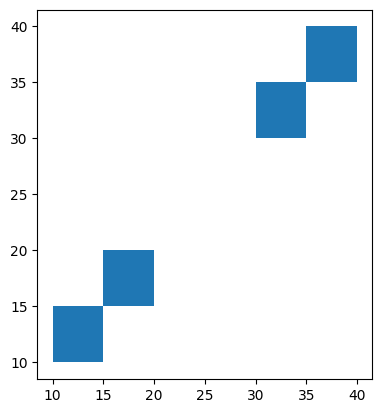

In [21]:
# resident と shopping area の空間的な(spatial)結合
# predicate = 'intersects' の場合
# intersection (共通部分) ゆえ，少しでも商圏がひっかかれば対象となる
joined_intersects = gpd.sjoin(residents, trade_areas, predicate='intersects')
print(joined_intersects)
joined_intersects.plot()

Empty GeoDataFrame
Columns: [resident, population, geometry, index_right, name]
Index: []


ValueError: aspect must be finite and positive 

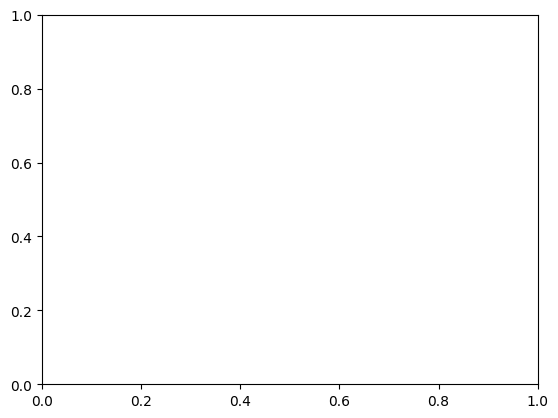

In [22]:
# resident と shopping area の空間的な(spatial)結合
# predicate = 'contains' の場合
# pop のエリアが shopping_area を包含するケースがないため，例外となる
joined_contains = gpd.sjoin(residents, trade_areas, predicate='contains')
print(joined_contains)
joined_contains.plot()